In [10]:
from jiwer import wer, cer
import json
import os

# Function to load data from a JSON file
def load_json_data(json_filepath: str):
    """
    Loads data from a JSON file and returns it as a Python dictionary.

    Args:
        json_filepath (str): Path to the JSON file.

    Returns:
        dict: Parsed JSON data.
    """
    with open(json_filepath, 'r', encoding='utf-8') as file:
        return json.load(file)

# Path to the JSON file for MOLINETTE dataset
molinette_json_filepath = r'/Users/benedettaperrone/Documents/TESI/VISUAL_STUDIO_CODE/whisper/MOLINETTE_combined/MOLINETTE_combined.json'

# Load JSON data
molinette_data = load_json_data(molinette_json_filepath)

# Function to extract the patient ID and on_off status from the MOLINETTE filename
def extract_id_from_molinette_filename(filename: str) -> tuple:
    """
    Extracts the patient ID and on_off status from the MOLINETTE filename based on the pattern after the first 'P'.

    Args:
        filename (str): The filename to extract the ID and on_off status from 
    Returns:
        tuple: (patient_id (str), on_off (str or None))
    """
    patient_id = ''
    on_off = None
    
    if filename.startswith('P'):
        # Extract ID for filenames that start with 'P'
        p_index = filename.find('P') + 1  # Get the index just after 'P'
        while p_index < len(filename) and filename[p_index].isdigit():
            patient_id += filename[p_index]
            p_index += 1
        if 'ON' in filename:
            on_off = 'on'
        elif 'OFF' in filename:
            on_off = 'off'
    elif filename.startswith('OP'):
        # Extract ID for filenames that start with 'OP'
        patient_id = filename[:5]  # Take 'OP' + first 3 digits as ID
        on_off = 'on'  # Files with 'OP' are assumed to be 'on'
        
    return patient_id, on_off

# Function to determine the reference text for MOLINETTE based on the filename
def get_reference_text_molinette(filename: str) -> str:
    """
    Determines the correct reference text for a MOLINETTE file based on its name.

    Args:
        filename (str): The filename to determine the reference text for.
s
    Returns:
        str or None: The reference text or None if not applicable.
    """
    # Example mapping of file identifiers to reference texts
    if 'PR1a' in filename or 'PR1b' in filename:
        return 'A caval donato non si guarda in bocca'
    elif 'PR2a' in filename or 'PR2b' in filename:
        return 'Meglio soli che mal accompagnati'
    # Add more mappings as needed based on filename patterns
    return None


# Function to determine group, task, and UPDRS based on file ID and dataset
def determine_group_and_task(file_id: str, json_data, file_onoff: str = None) -> tuple:
    """
    Determines the group (parkinson), task, and UPDRS associated with a file.

    Args:
        file_id (str): The extracted file ID.
        json_data (dict): The loaded JSON data for the MOLINETTE dataset.
        file_onoff (str, optional): The on_off status for MOLINETTE dataset. Defaults to None.

    Returns:
        tuple: (group (str), task (str), updrs (int or None))
    """
    for entry in json_data:
        # Ensure both ID and on_off status are matched
        if entry['id'] == file_id and entry.get('on_off') == file_onoff:
            task = entry['task'].replace(' ', '').lower()
            if task == 'proverb':
                group = 'parkinson'  # MOLINETTE dataset has only parkinson patients
                updrs = entry.get('updrs', None)
                return group, task, updrs
    return 'unknown', 'unknown', None

# Function to read the content of a text file
def read_file(filepath: str) -> str:
    """
    Reads the content of a text file.

    Args:
        filepath (str): Path to the text file.

    Returns:
        str: Content of the file.
    """
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read().strip()

from jiwer import wer, cer
import json
import os

# Function to calculate WER and CER for the MOLINETTE dataset by UPDRS levels (0, 1, and 2)
def calculate_wer_cer_for_molinette(directory: str, json_data) -> dict:
    """
    Calculates WER and CER for parkinson group based on reference texts, limited to UPDRS 0, 1, and 2.

    Args:
        directory (str): Path to the directory containing text files.
        json_data (dict): Loaded JSON data for the MOLINETTE dataset.

    Returns:
        dict: Calculated WER and CER statistics, including lists of WER/CER values by UPDRS level.
    """
    # Lists to store WER and CER values for all Parkinsonian files
    parkinsonian_wer = []
    parkinsonian_cer = []

    # Dictionaries to store raw WER and CER values by UPDRS level (only for UPDRS levels 0, 1, and 2)
    parkinsonian_wer_by_updrs = {i: [] for i in range(3)}
    parkinsonian_cer_by_updrs = {i: [] for i in range(3)}

    # List of all .txt files in the directory
    files = [f for f in os.listdir(directory) if f.endswith('.txt')]

    # Counters for the number of files in each UPDRS level
    parkinsonian_files_count = 0
    updrs_files_count = {i: 0 for i in range(3)}

    for file in files:
        # Extract file_id and on_off status (if applicable)
        file_id, file_onoff = extract_id_from_molinette_filename(file)

        if file_id is None:
            print(f"File ID not recognized for '{file}'")
            continue

        # Determine group, task, and UPDRS level
        group, task, updrs = determine_group_and_task(file_id, json_data, file_onoff)
        if group == 'unknown' or task == 'unknown' or updrs not in parkinsonian_wer_by_updrs:
            print(f"Skipping unrecognized group or task for '{file}'")
            continue

        # Get the reference text based on the task
        reference = get_reference_text_molinette(file)
        if reference is None:
            print(f"No reference text found for task '{task}' in file '{file}'")
            continue

        # Read the hypothesis text from the file
        file_path = os.path.join(directory, file)
        hypothesis = read_file(file_path)

        # Calculate WER and CER
        wer_value = wer(reference, hypothesis)
        cer_value = cer(reference, hypothesis)

        # Append WER and CER values to the overall lists and to the appropriate UPDRS level
        parkinsonian_wer.append(wer_value)
        parkinsonian_cer.append(cer_value)
        parkinsonian_files_count += 1
        parkinsonian_wer_by_updrs[updrs].append(wer_value)
        parkinsonian_cer_by_updrs[updrs].append(cer_value)
        updrs_files_count[updrs] += 1

    # Calculate average WER and CER for the overall Parkinsonian group
    avg_parkinsonian_wer = sum(parkinsonian_wer) / len(parkinsonian_wer) if parkinsonian_wer else float('inf')
    avg_parkinsonian_cer = sum(parkinsonian_cer) / len(parkinsonian_cer) if parkinsonian_cer else float('inf')

    # Calculate average WER and CER by UPDRS level (using the full list of values per level)
    avg_parkinsonian_wer_by_updrs = {
        i: (sum(parkinsonian_wer_by_updrs[i]) / len(parkinsonian_wer_by_updrs[i])) if parkinsonian_wer_by_updrs[i] else float('inf')
        for i in range(3)
    }
    avg_parkinsonian_cer_by_updrs = {
        i: (sum(parkinsonian_cer_by_updrs[i]) / len(parkinsonian_cer_by_updrs[i])) if parkinsonian_cer_by_updrs[i] else float('inf')
        for i in range(3)
    }

    return {
        'parkinsonian_wer': parkinsonian_wer,  # Full list of WER values
        'parkinsonian_cer': parkinsonian_cer,  # Full list of CER values
        'avg_parkinsonian_wer': avg_parkinsonian_wer,
        'avg_parkinsonian_cer': avg_parkinsonian_cer,
        'parkinsonian_files_count': parkinsonian_files_count,
        'updrs_files_count': updrs_files_count,
        'parkinsonian_wer_by_updrs': parkinsonian_wer_by_updrs,  # Raw WER values by UPDRS
        'parkinsonian_cer_by_updrs': parkinsonian_cer_by_updrs,  # Raw CER values by UPDRS
        'avg_parkinsonian_wer_by_updrs': avg_parkinsonian_wer_by_updrs,  # Average WER by UPDRS
        'avg_parkinsonian_cer_by_updrs': avg_parkinsonian_cer_by_updrs  # Average CER by UPDRS
    }

# Define the directory for the MOLINETTE dataset
molinette_directory = r'/Users/benedettaperrone/Documents/TESI/VISUAL_STUDIO_CODE/whisper/MOLINETTE_combined/dati'

# Calculate results for the MOLINETTE dataset
molinette_results = calculate_wer_cer_for_molinette(molinette_directory, molinette_data)

# Print final results for MOLINETTE
print("MOLINETTE Results by UPDRS:")
for updrs_level in range(3):  # Only UPDRS 0-2 are present in MOLINETTE
    print(f"UPDRS {updrs_level} - WER: {molinette_results['avg_parkinsonian_wer_by_updrs'][updrs_level]:.4f}, "
          f"CER: {molinette_results['avg_parkinsonian_cer_by_updrs'][updrs_level]:.4f}, "
          f"Files: {molinette_results['updrs_files_count'][updrs_level]}")

# Print the number of Parkinsonian audios from MOLINETTE
print("\nNumber of Parkinsonian audios from MOLINETTE:", molinette_results['parkinsonian_files_count'])


MOLINETTE Results by UPDRS:
UPDRS 0 - WER: 0.4604, CER: 0.1222, Files: 24
UPDRS 1 - WER: 0.5510, CER: 0.1625, Files: 24
UPDRS 2 - WER: 0.8578, CER: 0.3943, Files: 32

Number of Parkinsonian audios from MOLINETTE: 80


In [11]:
import numpy as np
import matplotlib.pyplot as plt


def remove_outliers_iqr(data):
    """Removes outliers using Tukey's IQR method and returns the clean data along with the list of outliers."""
    q1 = np.percentile(data, 25)  # First quartile (Q1)
    q3 = np.percentile(data, 75)  # Third quartile (Q3)
    iqr = q3 - q1  # Interquartile range (IQR)
    lower_bound = q1 - 1.5 * iqr  # Calculate lower bound
    upper_bound = q3 + 1.5 * iqr  # Calculate upper bound
    
    # Print bounds for debugging
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    
    # Separate data into clean data and outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    
    # Print outliers for debugging
    print(f"Outliers detected: {outliers}")
    
    return filtered_data, outliers


def boxplots_by_updrs(parkinsonian_values_by_updrs, metric_name="WER", dataset_label="Molinette dataset"):
    """
    Creates boxplots for a given metric_name (WER or CER) divided by UPDRS levels, including the control group.
    Outliers are displayed in the plot without appearing in the legend, with larger text for better readability.
    Additionally, it prints the numerosity for each group before and after outlier removal.
    """
    
    # Print numerosity before plotting
    print(f"\n### Numerosity Before Outlier Removal ###")
    for i in range(3):
        print(f"UPDRS {i}: {len(parkinsonian_values_by_updrs[i])}")
    
    parkinsonian_values_by_updrs_clean = []
    updrs_outliers = []
    
    for i in range(3):
        clean_data, outliers = remove_outliers_iqr(parkinsonian_values_by_updrs[i])
        parkinsonian_values_by_updrs_clean.append(clean_data)
        updrs_outliers.append(outliers)
    
    # Print outlier detection results
    for i in range(3):
        print(f"UPDRS {i} outliers: {updrs_outliers[i]}")
    
    # Prepare the data for the plot: control + UPDRS levels
    data =  parkinsonian_values_by_updrs_clean  # Add UPDRS 0 to 2
    
    # Create a figure for the boxplot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the boxplot with outliers shown
    boxplot = ax.boxplot(data, patch_artist=True, showmeans=True, meanline=True,
                         labels=[f'UPDRS {i}' for i in range(3)],  # Labels for each UPDRS level
                         boxprops=dict(facecolor='lightblue', color='black'),
                         medianprops=dict(color='red'),  # Red line for the median
                         meanprops=dict(color='green', linewidth=2),  # Green line for the mean
                         whiskerprops=dict(color='black'),  # Black whiskers
                         capprops=dict(color='black'),  # Black caps on the whiskers
                         flierprops=dict(markerfacecolor='black', marker='o', markersize=5))  # Black dots for outliers
    
    # Add title and axis labels
    ax.set_title(f'{metric_name} Distribution by UPDRS Levels ({dataset_label})', fontsize=16)  # Larger title
    ax.set_ylabel(metric_name, fontsize=14)  # Y-axis label with larger text
    
    # Adjust tick parameters instead of directly setting tick labels
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Add a custom legend for Mean and Median (without outliers)
    handles = [plt.Line2D([0], [0], color='green', label='Mean', linestyle='-'),
               plt.Line2D([0], [0], color='red', label='Median', linestyle='-')]
    
    # Add the legend
    ax.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)  # Larger legend text
    
    # Display the plot
    plt.tight_layout()
    plt.show()






In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boxplots_wer_cer(parkinsonian_wer, parkinsonian_cer, dataset_label="Dataset"):
    """Plots separate boxplots for WER and CER with Tukey's outlier removal, showing numerosity and outliers with larger text."""
    
    # Print numerosity before outlier removal
    print(f"\n### Numerosity Before Outlier Removal ###")
    print(f"WER - Parkinsonian group: {len(parkinsonian_wer)}")
    print(f"CER - Parkinsonian group: {len(parkinsonian_cer)}")
    
    # Calculate mean, median, and standard deviation before outlier removal and print them
    wer_mean, wer_median, wer_std = np.mean(parkinsonian_wer), np.median(parkinsonian_wer), np.std(parkinsonian_wer, ddof=1)
    cer_mean, cer_median, cer_std = np.mean(parkinsonian_cer), np.median(parkinsonian_cer), np.std(parkinsonian_cer, ddof=1)
    print(f"\n### WER Statistics (Before Outlier Removal) ###")
    print(f"WER Mean: {wer_mean:.3f}")
    print(f"WER Median: {wer_median:.3f}")
    print(f"WER Std Dev: {wer_std:.3f}")
    
    print(f"\n### CER Statistics (Before Outlier Removal) ###")
    print(f"CER Mean: {cer_mean:.3f}")
    print(f"CER Median: {cer_median:.3f}")
    print(f"CER Std Dev: {cer_std:.3f}")
    # Remove outliers using Tukey's method
    parkinsonian_wer_clean, wer_outliers = remove_outliers_iqr(parkinsonian_wer)
    parkinsonian_cer_clean, cer_outliers = remove_outliers_iqr(parkinsonian_cer)
    
    # Print numerosity after outlier removal
    print(f"\n### Numerosity After Outlier Removal ###")
    print(f"WER - Parkinsonian group: {len(parkinsonian_wer_clean)} (outliers: {len(wer_outliers)})")
    print("WER Outliers:", wer_outliers)  # Debugging print for WER outliers
    print(f"CER - Parkinsonian group: {len(parkinsonian_cer_clean)} (outliers: {len(cer_outliers)})")
    print("CER Outliers:", cer_outliers)  # Debugging print for CER outliers
    
    # Create a figure for WER
    plt.figure(figsize=(8, 6))
    plt.boxplot(parkinsonian_wer_clean, patch_artist=True, showmeans=True, meanline=True, 
                labels=['Parkinsonians'], 
                widths=0.1,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                meanprops=dict(color='green', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='', markersize=0))  # Disables default outliers

    # Add outliers manually for WER
    plt.scatter([1] * len(wer_outliers), wer_outliers, color='black', marker='o')
    plt.title(f'WER Distribution for Parkinsonians ({dataset_label})', fontsize=16)
    plt.ylabel('WER', fontsize=16)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    # Add custom legend for Mean and Median
    handles = [plt.Line2D([0], [0], color='green', label='Mean', linestyle='-'),
               plt.Line2D([0], [0], color='red', label='Median', linestyle='-')]
    plt.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    plt.show()
    
    # Create a separate figure for CER
    plt.figure(figsize=(8, 6))
    plt.boxplot(parkinsonian_cer_clean, patch_artist=True, showmeans=True, meanline=True, 
                labels=['Parkinsonians'], 
                widths=0.1,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='red'),
                meanprops=dict(color='green', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(marker='', markersize=0))  # Disables default outliers

    # Add outliers manually for CER
    plt.scatter([1] * len(cer_outliers), cer_outliers, color='black', marker='o')
    plt.title(f'CER Distribution for Parkinsonians ({dataset_label})', fontsize=16)
    plt.ylabel('CER', fontsize=16)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    # Add custom legend for Mean and Median
    plt.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    plt.show()


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def remove_outliers_iqr(data):
    """Removes outliers using Tukey's IQR method and returns the clean data along with the list of outliers."""
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter data into clean data and outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    outliers = [x for x in data if x < lower_bound or x > upper_bound]
    
    return filtered_data, outliers

def prepare_data_and_outliers(data_by_updrs, metric_name):
    """
    Prepares clean data and outliers for each UPDRS level by applying remove_outliers_iqr,
    and prints information about the outliers.
    
    Args:
        data_by_updrs (dict): Dictionary with UPDRS levels as keys and lists of data as values.
        metric_name (str): Name of the metric (WER or CER).
    
    Returns:
        clean_data_by_updrs (dict): Dictionary with UPDRS levels as keys and cleaned data as values.
        outliers_by_updrs (dict): Dictionary with UPDRS levels as keys and outliers as values.
    """
    clean_data_by_updrs = {}
    outliers_by_updrs = {}
    
    for updrs_level, data in data_by_updrs.items():
        clean_data, outliers = remove_outliers_iqr(data)
        clean_data_by_updrs[updrs_level] = clean_data
        outliers_by_updrs[updrs_level] = outliers
        
        # Print information about outliers
        print(f"\n### {metric_name} - UPDRS {updrs_level} ###")
        print(f"Total Outliers: {len(outliers)}")
        print("Outlier Values:", outliers)
    
    return clean_data_by_updrs, outliers_by_updrs

def plot_boxplots_with_outliers(data_by_updrs, outliers_by_updrs, metric_name="WER", dataset_label="Molinette"):
    """
    Plots separate boxplots for each UPDRS level, and manually adds outliers using scatter to ensure visibility.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for box plot using clean data
    data = [data_by_updrs[updrs] for updrs in range(len(data_by_updrs))]
    labels = [f'UPDRS {updrs}' for updrs in range(len(data_by_updrs))]
    
    box = ax.boxplot(data, patch_artist=True, showmeans=True, meanline=True,
                     labels=labels,
                     widths=0.3,  # Reduced width for narrower boxes
                     boxprops=dict(facecolor='lightblue', color='black'),
                     medianprops=dict(color='red'),
                     meanprops=dict(color='green', linewidth=2, marker=''),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     flierprops=dict(marker='', markersize=0))  # Disable automatic outlier markers

    # Add custom legend for Mean and Median
    handles = [plt.Line2D([0], [0], color='green', label='Mean', linestyle='-'),
               plt.Line2D([0], [0], color='red', label='Median', linestyle='-')]
    ax.legend(handles=handles, loc='upper right', frameon=True, shadow=True, fontsize=12)
    
    # Plot outliers manually using scatter
    for updrs_level, outliers in outliers_by_updrs.items():
        x_positions = np.full(len(outliers), updrs_level + 1)
        ax.scatter(x_positions, outliers, color='black', marker='o', s=30)
    
    # Add title and labels
    ax.set_title(f'{metric_name} Distribution by UPDRS Levels ({dataset_label})', fontsize=18)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    plt.tight_layout()
    plt.show()





### Numerosity Before Outlier Removal ###
WER - Parkinsonian group: 80
CER - Parkinsonian group: 80

### WER Statistics (Before Outlier Removal) ###
WER Mean: 0.647
WER Median: 0.600
WER Std Dev: 0.354

### CER Statistics (Before Outlier Removal) ###
CER Mean: 0.243
CER Median: 0.135
CER Std Dev: 0.283

### Numerosity After Outlier Removal ###
WER - Parkinsonian group: 78 (outliers: 2)
WER Outliers: [2.2, 1.6]
CER - Parkinsonian group: 70 (outliers: 10)
CER Outliers: [1.59375, 0.7567567567567568, 0.7837837837837838, 1.162162162162162, 0.59375, 0.8918918918918919, 0.71875, 1.03125, 0.8378378378378378, 0.8108108108108109]


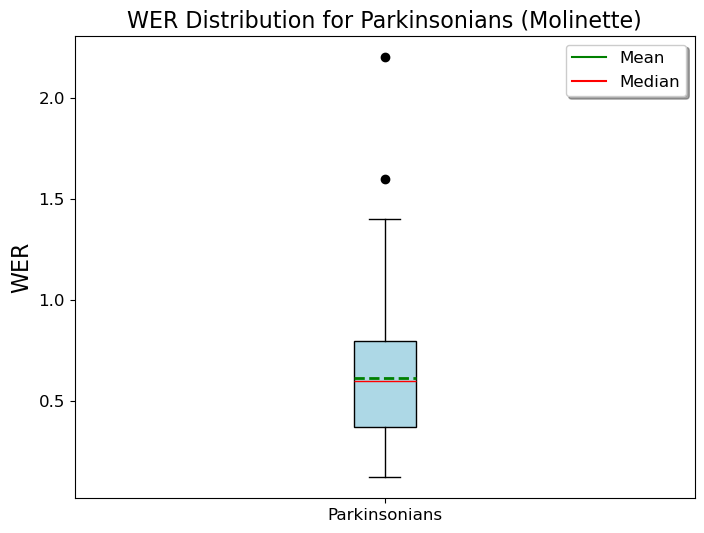

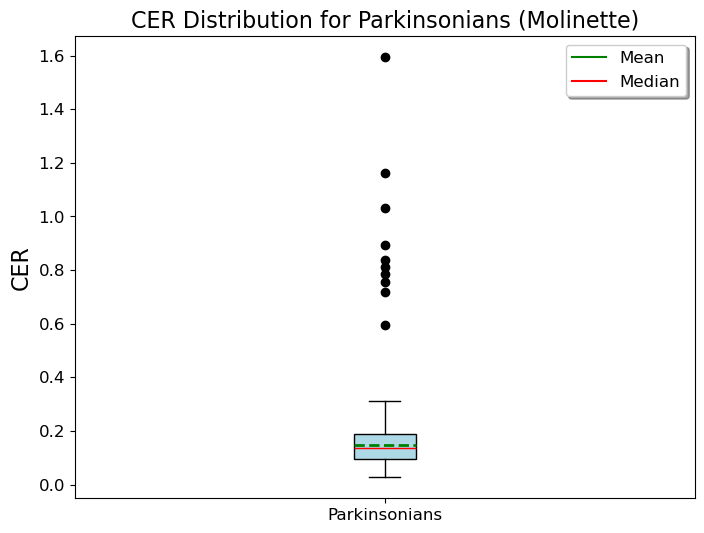

In [14]:
# Calculate WER and CER and print results
results = calculate_wer_cer_for_molinette(molinette_directory, molinette_data)

parkinsonian_wer = results['parkinsonian_wer']
parkinsonian_cer = results['parkinsonian_cer']
parkinsonian_wer_by_updrs = results['parkinsonian_wer_by_updrs']
parkinsonian_cer_by_updrs = results['parkinsonian_cer_by_updrs']

# Plotting boxplots for WER and CER with outliers
plot_boxplots_wer_cer(parkinsonian_wer, parkinsonian_cer, dataset_label="Molinette")




### WER - UPDRS 0 ###
Total Outliers: 0
Outlier Values: []

### WER - UPDRS 1 ###
Total Outliers: 1
Outlier Values: [1.125]

### WER - UPDRS 2 ###
Total Outliers: 1
Outlier Values: [2.2]

### CER - UPDRS 0 ###
Total Outliers: 1
Outlier Values: [0.3125]

### CER - UPDRS 1 ###
Total Outliers: 3
Outlier Values: [0.28125, 0.3125, 0.8108108108108109]

### CER - UPDRS 2 ###
Total Outliers: 1
Outlier Values: [1.59375]


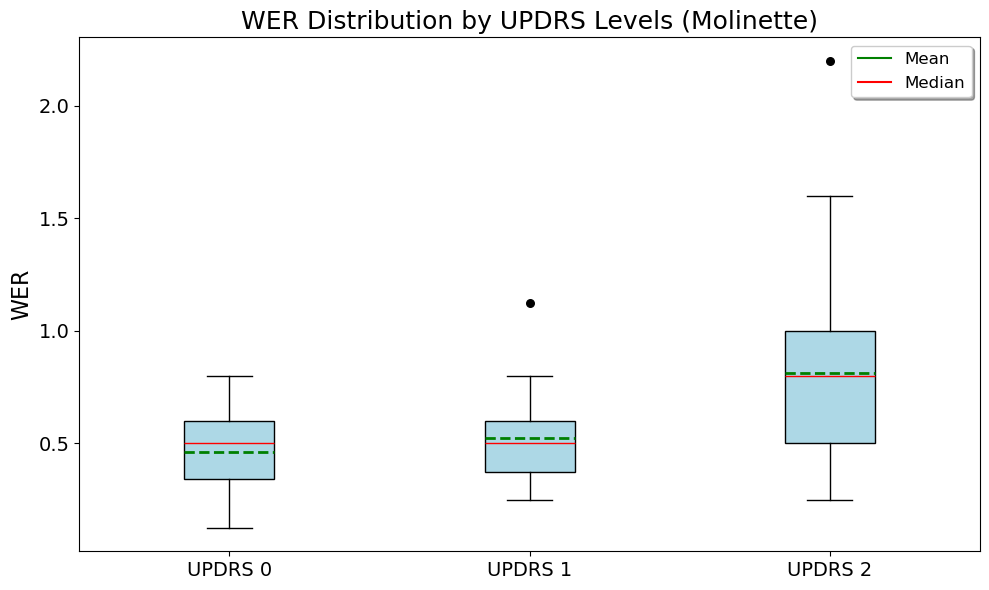

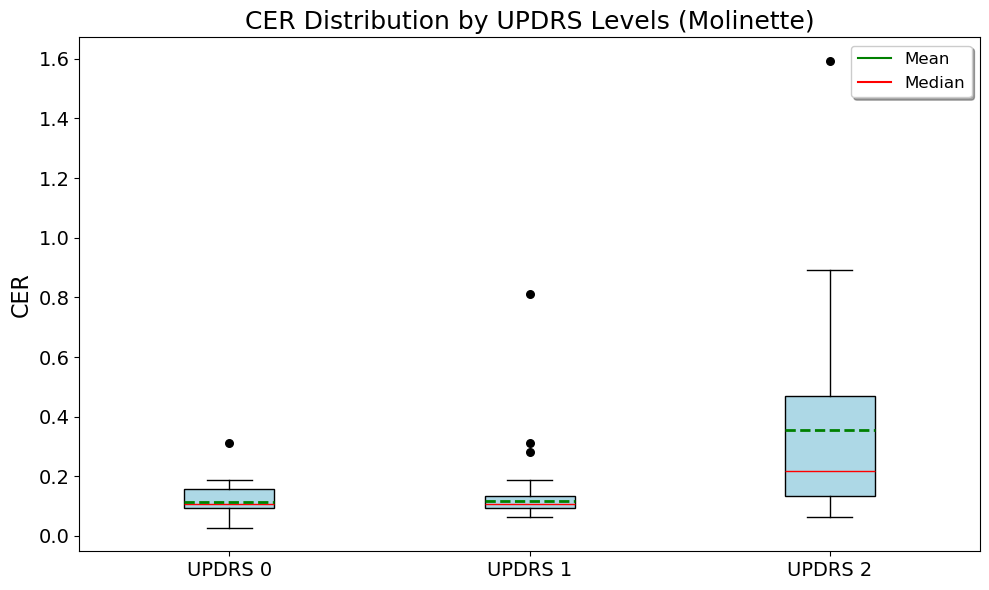

In [15]:
# Assuming `parkinsonian_wer_by_updrs` and `parkinsonian_cer_by_updrs` are dictionaries with data by UPDRS level
clean_wer_by_updrs, wer_outliers_by_updrs = prepare_data_and_outliers(parkinsonian_wer_by_updrs, "WER")
clean_cer_by_updrs, cer_outliers_by_updrs = prepare_data_and_outliers(parkinsonian_cer_by_updrs, "CER")

# Plot WER and CER with outliers for each UPDRS level
plot_boxplots_with_outliers(clean_wer_by_updrs, wer_outliers_by_updrs, metric_name="WER", dataset_label="Molinette")
plot_boxplots_with_outliers(clean_cer_by_updrs, cer_outliers_by_updrs, metric_name="CER", dataset_label="Molinette")



In [16]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, f_oneway, kruskal
from scikit_posthocs import posthoc_dunn  # Ensure scikit_posthocs is installed

def summary_statistics_and_tests(parkinsonian_wer, parkinsonian_wer_by_updrs,
                                 parkinsonian_cer, parkinsonian_cer_by_updrs,
                                 parkinsonian_wer_by_updrs_clean, parkinsonian_cer_by_updrs_clean,
                                 output_filename="summary_statistics_and_tests_Molinette_combined.csv", alpha=0.05):
    """
    Calculates summary statistics, performs normality and significance tests on WER and CER,
    performs Dunn's post hoc test if Kruskal-Wallis test is significant, displays results, 
    and saves them to a CSV file.
    """
    
    # Define UPDRS levels (0 to 2)
    updrs_levels = [f'UPDRS {i}' for i in range(3)]
    
    # Step 1: Display sample sizes for each UPDRS level
    updrs_counts = {f'UPDRS {i}': len(parkinsonian_wer_by_updrs[i]) for i in range(3)}
    print("\n### Group Sizes (Numerosity) ###")
    for level, count in updrs_counts.items():
        print(f"{level}: {count} samples")

    # Step 2: Calculate Summary Statistics for WER and CER, including mean, median, and standard deviation
    wer_stats = {
        'Group': ['Parkinsonians'] + updrs_levels,
        'WER Mean': [np.mean(parkinsonian_wer)] + [np.mean(parkinsonian_wer_by_updrs[i]) for i in range(3)],
        'WER Median': [np.median(parkinsonian_wer)] + [np.median(parkinsonian_wer_by_updrs[i]) for i in range(3)],
        'WER Std Dev': [np.std(parkinsonian_wer, ddof=1)] + [np.std(parkinsonian_wer_by_updrs[i], ddof=1) for i in range(3)],
        'Sample Size': [len(parkinsonian_wer)] + [len(parkinsonian_wer_by_updrs[i]) for i in range(3)]
    }
    cer_stats = {
        'Group': ['Parkinsonians'] + updrs_levels,
        'CER Mean': [np.mean(parkinsonian_cer)] + [np.mean(parkinsonian_cer_by_updrs[i]) for i in range(3)],
        'CER Median': [np.median(parkinsonian_cer)] + [np.median(parkinsonian_cer_by_updrs[i]) for i in range(3)],
        'CER Std Dev': [np.std(parkinsonian_cer, ddof=1)] + [np.std(parkinsonian_cer_by_updrs[i], ddof=1) for i in range(3)],
        'Sample Size': [len(parkinsonian_cer)] + [len(parkinsonian_cer_by_updrs[i]) for i in range(3)]
    }
    
    # Step 3: Convert to DataFrames for easier display and saving
    wer_df = pd.DataFrame(wer_stats)
    cer_df = pd.DataFrame(cer_stats)
    
    # Display WER and CER statistics
    print("\n### WER Summary Statistics ###")
    print(wer_df.to_string(index=False))
    print("\n### CER Summary Statistics ###")
    print(cer_df.to_string(index=False))
    
    # Save summary statistics to CSV file
    with open(output_filename, 'w') as f:
        wer_df.to_csv(f, index=False)
        f.write("\n\n")
        cer_df.to_csv(f, index=False)
    
    # Step 4: Perform Shapiro-Wilk normality test on WER and CER for each UPDRS level
    normality_results = {'Group': [], 'WER p-value': [], 'CER p-value': []}
    for i in range(3):
        normality_results['Group'].append(f'UPDRS {i}')
        
        # Shapiro-Wilk test for WER values in UPDRS i
        if len(parkinsonian_wer_by_updrs_clean[i]) > 2:  # Shapiro-Wilk requires at least 3 values
            wer_stat, wer_p_value = shapiro(parkinsonian_wer_by_updrs_clean[i])
            normality_results['WER p-value'].append(wer_p_value)
            print(f"For WER, UPDRS {i} {'does not have' if wer_p_value < alpha else 'has'} a normal distribution (p-value = {wer_p_value:.4f})")
        else:
            normality_results['WER p-value'].append(np.nan)
        
        # Shapiro-Wilk test for CER values in UPDRS i
        if len(parkinsonian_cer_by_updrs_clean[i]) > 2:
            cer_stat, cer_p_value = shapiro(parkinsonian_cer_by_updrs_clean[i])
            normality_results['CER p-value'].append(cer_p_value)
            print(f"For CER, UPDRS {i} {'does not have' if cer_p_value < alpha else 'has'} a normal distribution (p-value = {cer_p_value:.4f})")
        else:
            normality_results['CER p-value'].append(np.nan)

    # Convert normality results to DataFrame
    normality_df = pd.DataFrame(normality_results)
    print("\n### Shapiro-Wilk Normality Test Results ###")
    print(normality_df.to_string(index=False))
    
    # Save normality test results to CSV file
    with open(output_filename, 'a') as f:
        f.write("\n\n### Shapiro-Wilk Normality Test Results ###\n")
        normality_df.to_csv(f, index=False)
    
    # Step 5: Determine whether to use ANOVA or Kruskal-Wallis based on normality results
    significant_tests = {'Metric': [], 'Test': [], 'p-value': [], 'Conclusion': []}
    dunn_results = []

    # Test for WER
    valid_wer_data = [parkinsonian_wer_by_updrs_clean[i] for i in range(3) if len(parkinsonian_wer_by_updrs_clean[i]) > 2]
    if all(p_value > alpha for p_value in normality_df['WER p-value'] if not np.isnan(p_value)):
        if len(valid_wer_data) > 1:
            test_stat, p_value = f_oneway(*valid_wer_data)
            test_name = "ANOVA"
        else:
            p_value = np.nan
            test_name = "ANOVA (Insufficient data)"
    else:
        if len(valid_wer_data) > 1:
            test_stat, p_value = kruskal(*valid_wer_data)
            test_name = "Kruskal-Wallis"
            if p_value < alpha:
                #dunn_test_results = posthoc_dunn(valid_wer_data, p_adjust='bonferroni')
                dunn_test_results = posthoc_dunn(valid_wer_data)
                dunn_results.append(('WER', dunn_test_results))
        else:
            p_value = np.nan
            test_name = "Kruskal-Wallis (Insufficient data)"
    
    # Log WER significance test
    significant_tests['Metric'].append('WER')
    significant_tests['Test'].append(test_name)
    significant_tests['p-value'].append(p_value)
    conclusion = f"The difference is {'statistically significant' if p_value < alpha else 'not statistically significant'} at alpha = {alpha}." if not np.isnan(p_value) else "Insufficient data for valid test."
    significant_tests['Conclusion'].append(conclusion)
    
    # Test for CER
    valid_cer_data = [parkinsonian_cer_by_updrs_clean[i] for i in range(3) if len(parkinsonian_cer_by_updrs_clean[i]) > 2]
    if all(p_value > alpha for p_value in normality_df['CER p-value'] if not np.isnan(p_value)):
        if len(valid_cer_data) > 1:
            test_stat, p_value = f_oneway(*valid_cer_data)
            test_name = "ANOVA"
        else:
            p_value = np.nan
            test_name = "ANOVA (Insufficient data)"
    else:
        if len(valid_cer_data) > 1:
            test_stat, p_value = kruskal(*valid_cer_data)
            test_name = "Kruskal-Wallis"
            if p_value < alpha:
                #dunn_test_results = posthoc_dunn(valid_cer_data, p_adjust='bonferroni')
                dunn_test_results = posthoc_dunn(valid_cer_data)
                dunn_results.append(('CER', dunn_test_results))
        else:
            p_value = np.nan
            test_name = "Kruskal-Wallis (Insufficient data)"
    
    # Log CER significance test
    significant_tests['Metric'].append('CER')
    significant_tests['Test'].append(test_name)
    significant_tests['p-value'].append(p_value)
    conclusion = f"The difference is {'statistically significant' if p_value < alpha else 'not statistically significant'} at alpha = {alpha}." if not np.isnan(p_value) else "Insufficient data for valid test."
    significant_tests['Conclusion'].append(conclusion)
    
    # Convert to DataFrame for significance test results
    tests_df = pd.DataFrame(significant_tests)
    print("\n### Significance Test Results ###")
    print(tests_df.to_string(index=False))
    
    # Save significance test and Dunn's test results to CSV
    with open(output_filename, 'a') as f:
        f.write("\n\n### Significance Test Results ###\n")
        tests_df.to_csv(f, index=False)
        
        # Save Dunn's post hoc test results if Kruskal-Wallis was significant
        for metric, result in dunn_results:
            f.write(f"\n\n### Dunn's Post Hoc Test Results for {metric} ###\n")
            result.to_csv(f)
    
    # Display Dunn’s test results in a clear format for each UPDRS pair comparison
    for metric, result in dunn_results:
        print(f"\n### Dunn's Post Hoc Test Results for {metric} ###")
        print(result)
        
        # Interpreting Dunn's test results for each pair
        print("\nInterpreting Dunn's Test Results for each UPDRS pair:")
        for (index, p_value) in result.stack().items():
            level1, level2 = index
            interpretation = ("significantly different" if p_value < alpha else "not significantly different")
            print(f"UPDRS {level1} vs. UPDRS {level2}: {interpretation} (p-value = {p_value:.4f})")

    print("\n### Summary Statistics and Test Results Saved to CSV ###")
    
    return wer_df, cer_df, normality_df, tests_df, dunn_results

# Example usage
wer_df, cer_df, normality_df, tests_df, dunn_results = summary_statistics_and_tests(
    parkinsonian_wer=molinette_results['parkinsonian_wer'],
    parkinsonian_wer_by_updrs=molinette_results['parkinsonian_wer_by_updrs'],
    parkinsonian_cer=molinette_results['parkinsonian_cer'],
    parkinsonian_cer_by_updrs=molinette_results['parkinsonian_cer_by_updrs'],
    parkinsonian_wer_by_updrs_clean=clean_wer_by_updrs,
    parkinsonian_cer_by_updrs_clean=clean_cer_by_updrs,
    output_filename="summary_statistics_and_tests_Molinette_combined.csv",
    alpha=0.05
)




### Group Sizes (Numerosity) ###
UPDRS 0: 24 samples
UPDRS 1: 24 samples
UPDRS 2: 32 samples

### WER Summary Statistics ###
        Group  WER Mean  WER Median  WER Std Dev  Sample Size
Parkinsonians  0.646562      0.6000     0.354419           80
      UPDRS 0  0.460417      0.5000     0.198077           24
      UPDRS 1  0.551042      0.5000     0.200472           24
      UPDRS 2  0.857812      0.8375     0.425708           32

### CER Summary Statistics ###
        Group  CER Mean  CER Median  CER Std Dev  Sample Size
Parkinsonians  0.243106    0.135135     0.282723           80
      UPDRS 0  0.122185    0.116554     0.064437           24
      UPDRS 1  0.162479    0.125000     0.151433           24
      UPDRS 2  0.394267    0.218750     0.379030           32
For WER, UPDRS 0 has a normal distribution (p-value = 0.0550)
For CER, UPDRS 0 has a normal distribution (p-value = 0.1064)
For WER, UPDRS 1 does not have a normal distribution (p-value = 0.0185)
For CER, UPDRS 1 has a nor

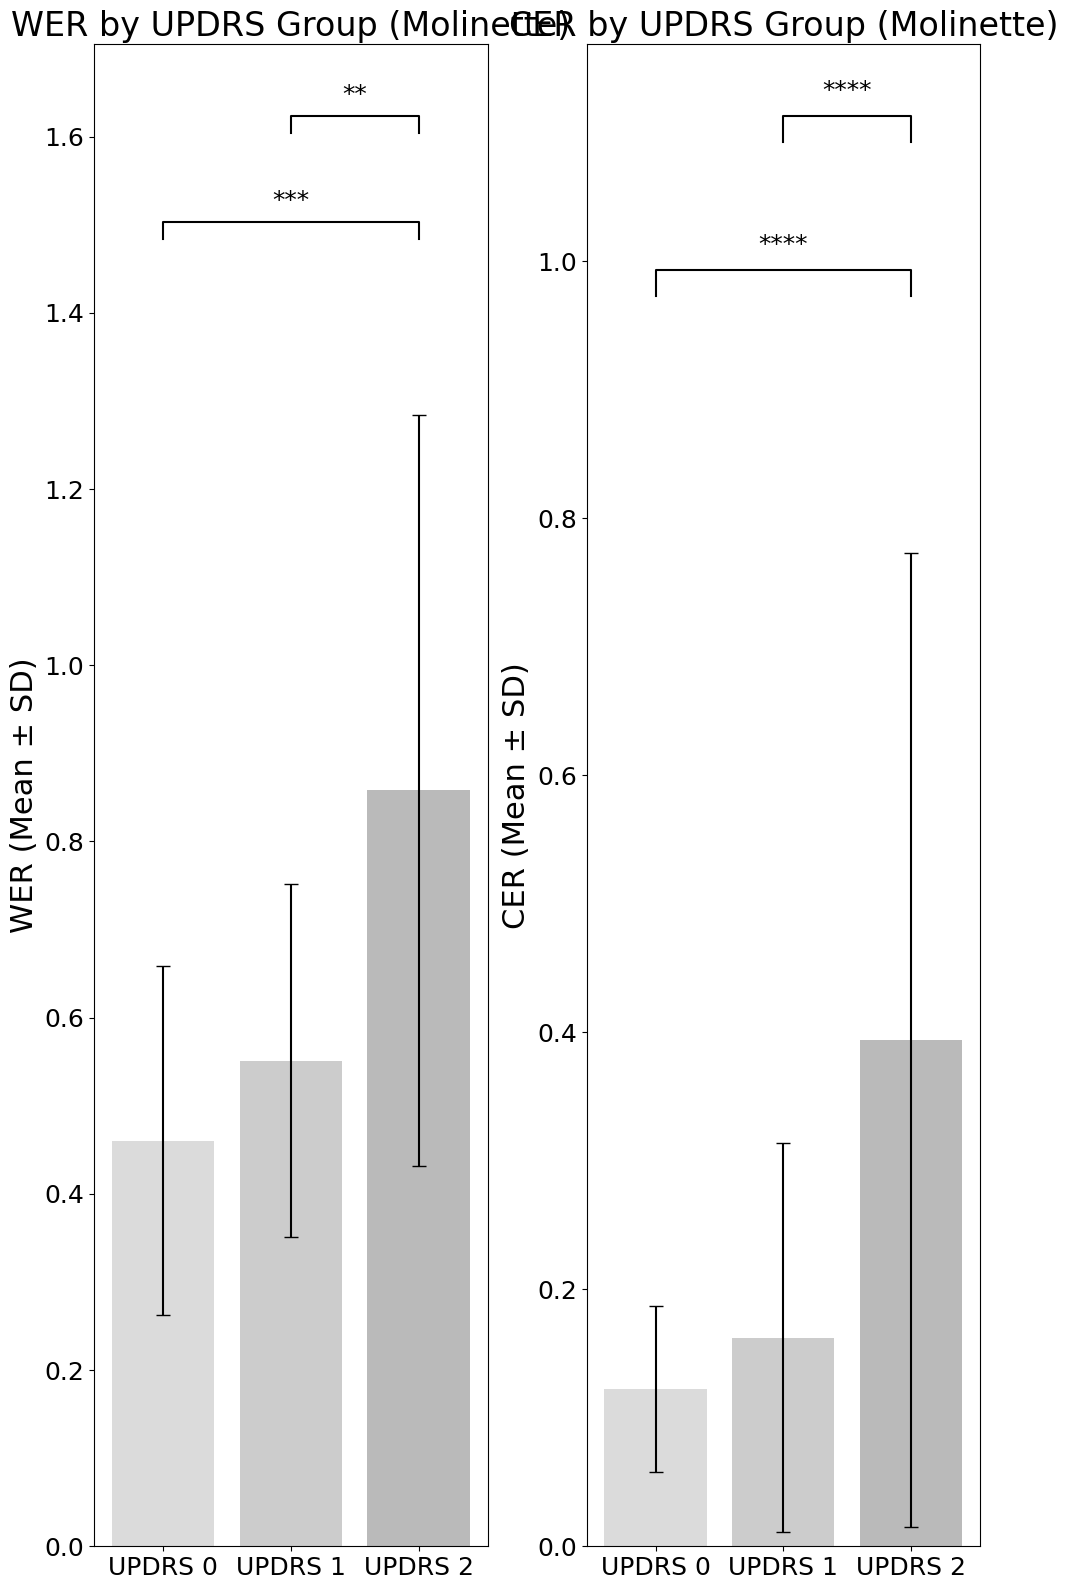

✅ Figure saved as 'statistics_molinette.pdf' and displayed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract means and standard deviations from the DataFrames
wer_means = wer_df['WER Mean'][1:4].values  # Only UPDRS 0, 1, 2
wer_stds = wer_df['WER Std Dev'][1:4].values
cer_means = cer_df['CER Mean'][1:4].values
cer_stds = cer_df['CER Std Dev'][1:4].values

# Define UPDRS groups and x positions
updrs_groups = ['UPDRS 0', 'UPDRS 1', 'UPDRS 2']
x_positions = np.arange(len(updrs_groups))

# Function to add significance annotations
def add_significance(ax, x1, x2, y, p_value, offset=0.02):
    if p_value < 0.0001:
        symbol = '****'
    elif p_value < 0.001:
        symbol = '***'
    elif p_value < 0.01:
        symbol = '**'
    elif p_value < 0.05:
        symbol = '*'
    else:
        return
    ax.plot([x1, x1, x2, x2], [y, y + offset, y + offset, y], color='black', linewidth=1.5)
    ax.text((x1 + x2) * 0.5, y + offset + 0.01, symbol, ha='center', va='bottom', color='black', fontsize=18)

# Colors for bars
bar_colors = ['lightgray', 'silver', 'darkgray']
height_offsets = {(0, 1): 0.08, (0, 2): 0.20, (1, 2): 0.32}

# Create figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 16))  # Larger figure for vertical layout

# WER Plot
ax = axes[0]
ax.bar(x_positions, wer_means, yerr=wer_stds, capsize=5, color=bar_colors, alpha=0.8)
ax.set_title('WER by UPDRS Group (Molinette)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(updrs_groups, fontsize=18)
ax.set_ylabel('WER (Mean ± SD)', fontsize=22)
ax.tick_params(axis='y', labelsize=18)

wer_significance = dunn_results[0][1]
for (i, j) in height_offsets:
    p_value = wer_significance.iloc[i, j]
    y = max(wer_means[i] + wer_stds[i], wer_means[j] + wer_stds[j]) + height_offsets[(i, j)]
    add_significance(ax, i, j, y, p_value, offset=0.02)

# CER Plot
ax = axes[1]
ax.bar(x_positions, cer_means, yerr=cer_stds, capsize=5, color=bar_colors, alpha=0.8)
ax.set_title('CER by UPDRS Group (Molinette)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(updrs_groups, fontsize=18)
ax.set_ylabel('CER (Mean ± SD)', fontsize=22)
ax.tick_params(axis='y', labelsize=18)

cer_significance = dunn_results[1][1]
for (i, j) in height_offsets:
    p_value = cer_significance.iloc[i, j]
    y = max(cer_means[i] + cer_stds[i], cer_means[j] + cer_stds[j]) + height_offsets[(i, j)]
    add_significance(ax, i, j, y, p_value, offset=0.02)

plt.tight_layout()

# Save as high-quality PDF
fig.savefig("/Users/benedettaperrone/Documents/TESI/TESI SCRITTA/Paper/Figures/statistics_molinette.pdf",
            format='pdf', bbox_inches='tight')

plt.show()

print("✅ Figure saved as 'statistics_molinette.pdf' and displayed.")



In [18]:
print(dunn_results)
for metric, result in dunn_results:
    print(f"{metric} Dunn's test result dimensions: {result.shape}")

[('WER',           1         2         3
1  1.000000  0.435716  0.000189
2  0.435716  1.000000  0.004209
3  0.000189  0.004209  1.000000), ('CER',           1         2         3
1  1.000000  0.975699  0.000062
2  0.975699  1.000000  0.000084
3  0.000062  0.000084  1.000000)]
WER Dunn's test result dimensions: (3, 3)
CER Dunn's test result dimensions: (3, 3)
